In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
import torch.nn.functional as F
import json
import math
from tqdm import tqdm
from collections import Counter
import pandas as pd
import re
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [2]:
class BertSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads):
        super().__init__()
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = int(hidden_size / num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(hidden_size, self.all_head_size)
        self.key = nn.Linear(hidden_size, self.all_head_size)
        self.value = nn.Linear(hidden_size, self.all_head_size)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, hidden_states, attention_mask=None):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = mixed_query_layer.view(
            mixed_query_layer.size(0), -1, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        key_layer = mixed_key_layer.view(
            mixed_key_layer.size(0), -1, self.num_attention_heads, self.attention_head_size).transpose(1, 2)
        value_layer = mixed_value_layer.view(
            mixed_value_layer.size(0), -1, self.num_attention_heads, self.attention_head_size).transpose(1, 2)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        if attention_mask is not None:
            attention_mask = attention_mask.unsqueeze(1).unsqueeze(3)
            attention_mask = attention_mask.expand(-1, self.num_attention_heads, -1, -1)
            attention_mask = attention_mask.to(dtype=attention_scores.dtype)  # Convert dtype to match
            attention_scores += (attention_mask * -10000.0)

        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.dropout(attention_probs)
        

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.transpose(1, 2).contiguous()
        context_layer = context_layer.view(context_layer.size(0), -1, self.all_head_size)
        return context_layer

class BertSelfOutput(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

class BertAttention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads):
        super().__init__()
        self.self = BertSelfAttention(hidden_size, num_attention_heads)
        self.output = BertSelfOutput(hidden_size)

    def forward(self, hidden_states, attention_mask=None):
        self_outputs = self.self(hidden_states, attention_mask)
        attention_output = self.output(self_outputs, hidden_states)
        return attention_output

class BertIntermediate(nn.Module):
    def __init__(self, hidden_size, intermediate_size):
        super().__init__()
        self.dense = nn.Linear(hidden_size, intermediate_size)
        self.intermediate_act_fn = nn.GELU()

    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states

class BertOutput(nn.Module):
    def __init__(self, intermediate_size, hidden_size):
        super().__init__()
        self.dense = nn.Linear(intermediate_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

class BertLayer(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, intermediate_size):
        super().__init__()
        self.attention = BertAttention(hidden_size, num_attention_heads)
        self.intermediate = BertIntermediate(hidden_size, intermediate_size)
        self.output = BertOutput(intermediate_size, hidden_size)

    def forward(self, hidden_states, attention_mask=None):
        attention_output = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

class BertEncoder(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, intermediate_size, num_hidden_layers):
        super().__init__()
        self.layer = nn.ModuleList([BertLayer(hidden_size, num_attention_heads, intermediate_size) for _ in range(num_hidden_layers)])

    def forward(self, hidden_states, attention_mask=None):
        for layer_module in self.layer:
            hidden_states = layer_module(hidden_states, attention_mask)
        return hidden_states

class BertEmbeddings(nn.Module):
    def __init__(self, vocab_size, hidden_size, max_position_embeddings):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, hidden_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(max_position_embeddings, hidden_size)
        self.token_type_embeddings = nn.Embedding(2, hidden_size)

        self.LayerNorm = nn.LayerNorm(hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_ids, token_type_ids=None):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)

        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        words_embeddings = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.token_type_embeddings(token_type_ids)

        embeddings = words_embeddings + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

class BertModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_attention_heads, intermediate_size, num_hidden_layers, max_position_embeddings):
        super().__init__()
        self.embeddings = BertEmbeddings(vocab_size, hidden_size, max_position_embeddings)
        self.encoder = BertEncoder(hidden_size, num_attention_heads, intermediate_size, num_hidden_layers)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None):
        embeddings = self.embeddings(input_ids, token_type_ids)
        encoder_outputs = self.encoder(embeddings, attention_mask)
        return encoder_outputs

class BertForTokenClassification(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_attention_heads, intermediate_size, num_hidden_layers, max_position_embeddings, num_labels):
        super().__init__()
        self.num_labels = num_labels
        self.hidden_size = hidden_size
        self.bert = BertModel(vocab_size, hidden_size, num_attention_heads, intermediate_size, num_hidden_layers, max_position_embeddings)
        self.dropout = nn.Dropout(p=0.1)
        self.classifier = nn.Linear(hidden_size, num_labels)
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids, token_type_ids, attention_mask)
        sequence_output = self.dropout(outputs)
        logits = self.classifier(sequence_output)

        if labels is None:
            return logits
        
        active_loss = labels.view(-1) != -100
        active_logits = logits.view(-1, self.num_labels)[active_loss]
        active_labels = labels.view(-1)[active_loss]
        loss = self.loss_fn(active_logits, active_labels)

        return {'logits':logits, 'loss':loss}
    def update_num_labels(self, num_labels):
        self.num_labels = num_labels
        self.classifier = nn.Linear(self.hidden_size, num_labels)



In [3]:
class CustomTokenizer:
    def __init__(self, vocab_file, config_file, special_tokens_file):
        with open(vocab_file, 'r', encoding='utf-8') as file:
            self.vocab = {line.strip(): idx for idx, line in enumerate(file.readlines())}
        self.id_to_token = {idx: token for token, idx in self.vocab.items()}
        
        with open(config_file, 'r', encoding='utf-8') as file:
            self.config = json.load(file)
        
        with open(special_tokens_file, 'r', encoding='utf-8') as file:
            self.special_tokens = json.load(file)
        self.current_word_indices = []
        self.pad_token_id = self.vocab[self.special_tokens['pad_token']]
    def tokenize(self, text):
        tokens = []
        self.current_word_indices = []
        for word_index, word in enumerate(text):  # Split on spaces by default
            sub_tokens = self.word_piece_tokenize(word)
            tokens.extend(sub_tokens)
            self.current_word_indices.extend([word_index] * len(sub_tokens))
        return tokens

    def word_piece_tokenize(self, word):
        sub_tokens = []
        start = 0
        while start < len(word):
            matched = False
            for length in range(len(word), start, -1):
                subword = ('' if start == 0 else '##') + word[start:length]
                if subword in self.vocab:
                    sub_tokens.append(subword)
                    start = length
                    matched = True
                    break
            if not matched:
                sub_tokens.append('##' + word[start] if start > 0 else self.special_tokens['unk_token'])
                start += 1
        return sub_tokens

    def word_ids(self):
        return self.current_word_indices

    def convert_tokens_to_ids(self, tokens):
        return [self.vocab.get(token, self.vocab.get(self.special_tokens['unk_token'])) for token in tokens]

    def convert_ids_to_tokens(self, ids):
        return [self.id_to_token.get(id, self.special_tokens['unk_token']) for id in ids]

    def encode(self, text, text_pair=None, max_length=None, truncation=False, padding='max_length', is_split_into_words=False):
        if is_split_into_words:
            text = [i.lower() for i in text]  # Splits the text into words if not already split
        tokens = ['[CLS]'] + self.tokenize(text) + ['[SEP]']
        token_type_ids = [0] * len(tokens)
        self.current_word_indices = [None] + self.current_word_indices + [None]

        if text_pair:
            pair_tokens = self.tokenize(text_pair)
            tokens += pair_tokens + ['[SEP]']
            token_type_ids += [1] * (len(pair_tokens) + 1)
            self.current_word_indices += [None] * (len(pair_tokens) + 1)  

        input_ids = self.convert_tokens_to_ids(tokens)
        
        if truncation and max_length:
            input_ids = input_ids[:max_length]
            token_type_ids = token_type_ids[:max_length]
            self.current_word_indices = self.current_word_indices[:max_length]
        
        attention_mask = [1] * len(input_ids)
        
        if padding and max_length:
            padding_length = max_length - len(input_ids)
            input_ids += [self.vocab.get(self.special_tokens['pad_token'])] * padding_length
            token_type_ids += [0] * padding_length
            attention_mask += [0] * padding_length
            self.current_word_indices += [None] * padding_length 

        return {
            "input_ids": input_ids,
            "token_type_ids": token_type_ids,
            "attention_mask": attention_mask,
            "word_ids": self.current_word_indices  
        }
    
    def __call__(self, text, text_pair=None, max_length=None, truncation=False, padding='max_length', is_split_into_words=False):
        return self.encode(text, text_pair, max_length, truncation, padding, is_split_into_words)

In [4]:
tokenizer = CustomTokenizer('./tokenizer/vocab.txt', './tokenizer/tokenizer_config.json', './tokenizer/special_tokens_map.json')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
vocab_size = 28996
hidden_size = 768
num_attention_heads = 12
intermediate_size = 3072
num_hidden_layers = 12
max_position_embeddings = 512
num_labels = 7

model = BertForTokenClassification(vocab_size, hidden_size, num_attention_heads, intermediate_size, num_hidden_layers, max_position_embeddings, num_labels)

model_path = '../va.pth'  
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')), strict=False)
model.to(device)

model.update_num_labels(43)
# for param in model.parameters():
#     param.requires_grad = False

# for param in model.classifier.parameters():
#     param.requires_grad = True

print(model)

In [6]:
import numpy as np
from transformers import AutoModelForTokenClassification
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from torch.nn.utils import clip_grad_norm_
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

"""
Data can be found at Harvard:
training, val, test tsv file data looks like this:

Mr. O
Steiner B-PATIENT
is O
scheduled O
today. O
Patient O
has O
not O
been O
seen O
since O
November B-DATE
. O

"""


def write_predictions_to_file(model, data_loader, device, idx2tag, output_file):
    model.eval()
    
    with open(output_file, 'w') as f:
        with torch.no_grad():
            for batch in tqdm(data_loader, desc="Writing predictions"):
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                logits = outputs.logits
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                
                logits = logits.detach().cpu().numpy()
                input_ids = input_ids.detach().cpu().numpy()
                attention_mask = attention_mask.detach().cpu().numpy()
                
                for seq_idx in range(len(input_ids)):
                    tokens = tokenizer.convert_ids_to_tokens(input_ids[seq_idx])
                    pred_labels = np.argmax(logits[seq_idx], axis=1)
                    mask = attention_mask[seq_idx]
                    
                    current_word = ""
                    current_word_label = None
                    
                    for token_idx in range(len(tokens)):
                        if not mask[token_idx]:
                            break
                        token = tokens[token_idx]
                        pred_label = idx2tag[pred_labels[token_idx]]
                        
                        if token in [tokenizer.pad_token, tokenizer.cls_token, tokenizer.sep_token]:
                            continue
                            
                        # Handle subwords while preserving punctuation
                        if token.startswith("##"):
                            current_word += token[2:]
                        else:
                            if current_word:
                                f.write(f"{current_word} {current_word_label}\n")
                            current_word = token
                            current_word_label = pred_label
                    
                    if current_word:
                        f.write(f"{current_word} {current_word_label}\n")
                    
                    f.write("\n")


def get_entities_from_iob(seq):

    entities = []
    current_entity = None
    current_start = None
    current_label = None
    
    for i, tag in enumerate(seq):
        if tag == "O" or tag.startswith("B-"):
            # If we were tracking an entity, close it out
            if current_entity is not None:
                entities.append((current_entity, current_start, i - 1))
                current_entity = None
                current_start = None
            # Start of a new entity?
            if tag.startswith("B-"):
                current_entity = tag[2:]  # remove the "B-"
                current_start = i
                
        elif tag.startswith("I-"):
            # Continue the current entity if it matches the same type
            if current_entity is None:
                # This handles a corner case: "I-*" appears without a preceding "B-*"
                current_entity = tag[2:]
                current_start = i
            else:
                # Check if we switched to a different entity type incorrectly
                current_label = tag[2:]
                if current_label != current_entity:
                    # Close out the previous entity and start a new one
                    entities.append((current_entity, current_start, i - 1))
                    current_entity = current_label
                    current_start = i
        else:
            # Shouldn't happen with standard IOB, but just in case
            pass

    # If we ended in the middle of an entity
    if current_entity is not None:
        entities.append((current_entity, current_start, len(seq) - 1))
    
    return entities

def compute_chunk_metrics(true_list, pred_list):

    assert len(true_list) == len(pred_list), "Number of examples differs!"
    
    true_entities_all = 0
    pred_entities_all = 0
    match_entities_all = 0
    
    # For label-wise stats
    label_wise_stats = defaultdict(lambda: {"TP": 0, "FP": 0, "FN": 0})
    
    for true_seq, pred_seq in zip(true_list, pred_list):
        true_entities = get_entities_from_iob(true_seq)
        pred_entities = get_entities_from_iob(pred_seq)
        
        # Convert to sets for direct matching
        # We'll store them as (type, start, end)
        true_set = set(true_entities)
        pred_set = set(pred_entities)
        
        # For micro-averaging
        true_entities_all += len(true_set)
        pred_entities_all += len(pred_set)
        
        # Count matches
        matches = true_set.intersection(pred_set)
        match_entities_all += len(matches)
        
        # --- Label-wise stats ---
        # We'll track each entity in sets by label
        # A chunk is identified by the entity type.
        
        # Tally for each entity in "true_set"
        for ent in true_set:
            label = ent[0]
            # If it's not matched, it counts as FN
            if ent in matches:
                label_wise_stats[label]["TP"] += 1
            else:
                label_wise_stats[label]["FN"] += 1
        
        # Tally for each entity in "pred_set"
        for ent in pred_set:
            label = ent[0]
            # If it's not matched, it counts as FP
            if ent not in matches:
                label_wise_stats[label]["FP"] += 1

    # Compute overall micro P/R/F
    if pred_entities_all == 0:
        precision = 0.0
    else:
        precision = match_entities_all / pred_entities_all
    
    if true_entities_all == 0:
        recall = 0.0
    else:
        recall = match_entities_all / true_entities_all
    
    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    
    # Build a simple label-wise classification report
    classification_report_str = "label\tprecision\trecall\tf1\t\n"
    for label, stats in sorted(label_wise_stats.items()):
        tp = stats["TP"]
        fp = stats["FP"]
        fn = stats["FN"]
        if (tp + fp) == 0:
            precision_label = 0.0
        else:
            precision_label = tp / (tp + fp)
        if (tp + fn) == 0:
            recall_label = 0.0
        else:
            recall_label = tp / (tp + fn)
        if precision_label + recall_label == 0:
            f1_label = 0.0
        else:
            f1_label = 2 * precision_label * recall_label / (precision_label + recall_label)

        classification_report_str += (
            f"{label}\t"
            f"{precision_label:.4f}\t"
            f"{recall_label:.4f}\t"
            f"{f1_label:.4f}\n"
        )

    # Add overall micro-average
    classification_report_str += (
        "\nOverall micro-average precision: {:.4f}\n".format(precision)
        + "Overall micro-average recall:    {:.4f}\n".format(recall)
        + "Overall micro-average f1:       {:.4f}\n".format(f1)
    )
    
    return classification_report_str, {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


def compute_metrics(model, data_loader, device, idx2tag):
    model.eval()
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs["logits"]
            labels = batch['labels']
            
            # Move tensors to CPU and convert to numpy
            logits = logits.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            
            for i in range(len(labels)):
                pred_tags = []
                true_tags = []
                for j in range(len(labels[i])):
                    if labels[i][j] != -100:
                        # predicted label
                        pred_tag = idx2tag[np.argmax(logits[i][j])]
                        # gold label
                        true_tag = idx2tag[labels[i][j]]
                        pred_tags.append(pred_tag)
                        true_tags.append(true_tag)
                predictions.append(pred_tags)
                true_labels.append(true_tags)

    # Generate chunk-based classification report
    report, summary_dict = compute_chunk_metrics(true_labels, predictions)
    print(report)
    return report


train_path = '../data/train.tsv'
val_path = '../data/dev.tsv'
test_path = '../data/test.tsv'

def parse_tsv_to_sentences_with_tags(file_path):
    sentences_data = []
    current_words = []
    current_tags = []

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line:  # If the line is not empty
                if " " in line:
                    # Split only on the first space to preserve any spaces in the tag
                    parts = line.split(" ", 1)
                    if len(parts) == 2:
                        word, tag = parts
                        # Don't modify the word - keep it exactly as is
                        current_words.append(word)
                        current_tags.append(tag)
                    else:
                        print(f"Skipping malformed line: '{line}'")
            else:  # Empty line indicates end of a sentence
                if current_words and current_tags:
                    sentences_data.append((current_words, current_tags))
                    current_words = []
                    current_tags = []

    # Don't forget to add the last sentence if not empty
    if current_words and current_tags:
        sentences_data.append((current_words, current_tags))

    return pd.DataFrame(sentences_data, columns=['Sentence', 'Tag'])

# Parse the data
train_df = parse_tsv_to_sentences_with_tags(train_path)
val_df = parse_tsv_to_sentences_with_tags(val_path)
test_df = parse_tsv_to_sentences_with_tags(test_path)
all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

def process_data_for_training(train_df, val_df, test_df):
    all_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
    words = Counter()
    tags = Counter()
    
    for _, row in all_df.iterrows():
        words.update(row['Sentence'])
        tags.update(row['Tag'])

    word2idx = {word: i + 1 for i, (word, _) in enumerate(words.items())}
    word2idx['<UNK>'] = 0
    tag2idx = {tag: i for i, (tag, _) in enumerate(tags.items())}
    idx2tag = {i: tag for tag, i in tag2idx.items()}
    
    return word2idx, tag2idx, idx2tag

words = Counter()
tags = Counter()
for _, row in all_df.iterrows():
    words.update(row['Sentence'])
    tags.update(row['Tag'])

word2idx = {word: i + 1 for i, (word, _) in enumerate(words.items())}
word2idx['<UNK>'] = 0
tag2idx = {tag: i for i, (tag, _) in enumerate(tags.items())}
idx2tag = {i: tag for tag, i in tag2idx.items()}
label_list = [name for name, idx in tag2idx.items() ]
print(len(tag2idx))
print(tag2idx)

def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    labels = [item['labels'] for item in batch]

    # Padding
    input_ids_padded = pad_sequence(
        [torch.tensor(seq) for seq in input_ids], 
        batch_first=True, 
        padding_value=tokenizer.pad_token_id
    )
    labels_padded = pad_sequence(
        [torch.tensor(lab) for lab in labels], 
        batch_first=True, 
        padding_value=-100
    )

    return {
        'input_ids': input_ids_padded,
        'attention_mask': input_ids_padded != tokenizer.pad_token_id,
        'labels': labels_padded
    }

class CustomDataset:
    def __init__(self, dataframe, tokenizer, tag2idx, max_len=150):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.tag2idx = tag2idx
        self.max_len = max_len
        self.label_all_tokens = False

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_row = self.data.iloc[idx]
        sentence, tags = data_row['Sentence'], data_row['Tag']
        
        # Use is_split_into_words=True since our input is already tokenized
        tokenized_inputs = self.tokenizer(
        sentence,
        is_split_into_words=True,
        max_length=self.max_len,
        truncation=True,
        padding='max_length'
        )

        # Build label_ids from 'word_ids', but we won't return 'word_ids' to avoid None
        labels = [self.tag2idx.get(tag, -100) for tag in tags]
        word_ids = tokenized_inputs["word_ids"]  # has None for [CLS], [SEP], padding

        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            else:
                label_ids.append(labels[word_idx])
            previous_word_idx = word_idx

        tokenized_inputs['labels'] = label_ids

        # Remove the 'word_ids' field:
        del tokenized_inputs['word_ids']

        return {key: torch.tensor(val) for key, val in tokenized_inputs.items()}

# Create datasets and loaders
train_dataset = CustomDataset(train_df, tokenizer, tag2idx)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

test_dataset = CustomDataset(test_df, tokenizer, tag2idx)
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn)

val_dataset = CustomDataset(val_df, tokenizer, tag2idx)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_fn)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 1
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01) 
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=1,
    num_training_steps=len(train_loader) * num_epochs
)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs['loss']
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=0.7)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Average training loss: {total_loss / len(train_loader)}")
    
    # Evaluate on the validation set (we only write predictions to file here)
    #_ = write_predictions_to_file(model, val_loader, device, idx2tag, 'mytext.txt')
    val_report = compute_metrics(model, val_loader, device, idx2tag)
    print(val_report)

# Final evaluation on the test set (chunk-based metrics)
test_report = compute_metrics(model, test_loader, device, idx2tag)
print(test_report)


43
{'O': 0, 'B-DATE': 1, 'B-PATIENT': 2, 'I-PATIENT': 3, 'B-MEDICALRECORD': 4, 'B-DOCTOR': 5, 'I-DOCTOR': 6, 'B-AGE': 7, 'B-HOSPITAL': 8, 'I-HOSPITAL': 9, 'B-PHONE': 10, 'B-FAX': 11, 'B-PROFESSION': 12, 'B-COUNTRY': 13, 'B-IDNUM': 14, 'B-USERNAME': 15, 'B-STREET': 16, 'I-STREET': 17, 'B-CITY': 18, 'B-STATE': 19, 'B-ZIP': 20, 'I-DATE': 21, 'I-PHONE': 22, 'I-MEDICALRECORD': 23, 'I-CITY': 24, 'B-ORGANIZATION': 25, 'I-PROFESSION': 26, 'I-ORGANIZATION': 27, 'I-IDNUM': 28, 'B-HEALTHPLAN': 29, 'I-HEALTHPLAN': 30, 'B-DEVICE': 31, 'B-BIOID': 32, 'B-EMAIL': 33, 'I-COUNTRY': 34, 'B-LOCATION-OTHER': 35, 'I-LOCATION-OTHER': 36, 'I-AGE': 37, 'I-FAX': 38, 'I-STATE': 39, 'B-URL': 40, 'I-URL': 41, 'I-DEVICE': 42}


Training:   0%|          | 0/2872 [00:00<?, ?it/s]C:\Users\jstam\AppData\Local\Temp\ipykernel_19308\317212729.py:369: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(seq) for seq in input_ids],
C:\Users\jstam\AppData\Local\Temp\ipykernel_19308\317212729.py:374: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [torch.tensor(lab) for lab in labels],
Training: 100%|██████████| 2872/2872 [08:41<00:00,  5.51it/s]


Epoch 1/1
Average training loss: 0.08158660268870783


Evaluating: 100%|██████████| 309/309 [00:17<00:00, 18.12it/s]


label	precision	recall	f1	
AGE	0.9850	0.9632	0.9740
CITY	0.7521	0.9263	0.8302
COUNTRY	0.0000	0.0000	0.0000
DATE	0.9900	0.9845	0.9872
DOCTOR	0.9343	0.9373	0.9358
HOSPITAL	0.8904	0.8149	0.8510
IDNUM	0.9903	0.9111	0.9491
MEDICALRECORD	0.9400	0.9975	0.9679
ORGANIZATION	0.7778	0.5000	0.6087
PATIENT	0.8886	0.8123	0.8487
PHONE	0.8590	0.8121	0.8349
PROFESSION	0.6296	0.6800	0.6538
STATE	0.9773	0.8113	0.8866
STREET	0.8372	0.8000	0.8182
USERNAME	1.0000	1.0000	1.0000
ZIP	0.9892	1.0000	0.9946

Overall micro-average precision: 0.9561
Overall micro-average recall:    0.9424
Overall micro-average f1:       0.9492

label	precision	recall	f1	
AGE	0.9850	0.9632	0.9740
CITY	0.7521	0.9263	0.8302
COUNTRY	0.0000	0.0000	0.0000
DATE	0.9900	0.9845	0.9872
DOCTOR	0.9343	0.9373	0.9358
HOSPITAL	0.8904	0.8149	0.8510
IDNUM	0.9903	0.9111	0.9491
MEDICALRECORD	0.9400	0.9975	0.9679
ORGANIZATION	0.7778	0.5000	0.6087
PATIENT	0.8886	0.8123	0.8487
PHONE	0.8590	0.8121	0.8349
PROFESSION	0.6296	0.6800	0.6538
STATE	0.9773	0.8113

Evaluating: 100%|██████████| 2037/2037 [01:52<00:00, 18.03it/s]


label	precision	recall	f1	
AGE	0.9639	0.9780	0.9709
CITY	0.4368	0.7379	0.5487
COUNTRY	0.0000	0.0000	0.0000
DATE	0.9884	0.9912	0.9898
DEVICE	0.0000	0.0000	0.0000
DOCTOR	0.9280	0.9288	0.9284
EMAIL	0.0000	0.0000	0.0000
FAX	0.0000	0.0000	0.0000
HOSPITAL	0.8132	0.8628	0.8373
IDNUM	0.9242	0.8824	0.9028
LOCATION-OTHER	0.0000	0.0000	0.0000
MEDICALRECORD	0.8965	0.9841	0.9383
ORGANIZATION	0.4737	0.2885	0.3586
PATIENT	0.8715	0.8644	0.8679
PHONE	0.7407	0.7632	0.7517
PROFESSION	0.5290	0.6109	0.5670
STATE	0.7660	0.6585	0.7082
STREET	0.8877	0.8737	0.8806
USERNAME	0.9431	0.9559	0.9495
ZIP	0.9030	0.9270	0.9148

Overall micro-average precision: 0.9299
Overall micro-average recall:    0.9377
Overall micro-average f1:       0.9338

label	precision	recall	f1	
AGE	0.9639	0.9780	0.9709
CITY	0.4368	0.7379	0.5487
COUNTRY	0.0000	0.0000	0.0000
DATE	0.9884	0.9912	0.9898
DEVICE	0.0000	0.0000	0.0000
DOCTOR	0.9280	0.9288	0.9284
EMAIL	0.0000	0.0000	0.0000
FAX	0.0000	0.0000	0.0000
HOSPITAL	0.8132	0.8628	0.8373
IDNUM	0

In [7]:
all_tags = set()
for df in [train_df, val_df, test_df]:
    for tags in df["Tag"]:
        all_tags.update(tags)
all_tags = sorted(list(all_tags))

# Create dictionaries for label -> ID and ID -> label
label2id = {tag: i for i, tag in enumerate(all_tags)}
id2label = {i: tag for tag, i in label2id.items()}

In [8]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict

from functools import partial

import torch


from bert_attack_utils2 import(

    get_word_embeddings,
    get_char_table,
    greedy_5char_attack,
    genetic_5char_attack,
    compute_average_metrics,
    evaluate_attacks,
    similarity,
    PGD5CharAttacker
)

In [9]:
def get_cyrillic_char_table():
    return {
        'A': 'А',  # Cyrillic capital A
        'a': 'а',  # Cyrillic lowercase a
        'B': 'В',  # Cyrillic capital Ve
        'E': 'Е',  # Cyrillic capital Ye
        'e': 'е',  # Cyrillic small Ye
        'I': 'І',  # Cyrillic capital Byelorussian-Ukrainian I
        'i': 'і',  # Cyrillic small Byelorussian-Ukrainian i
        'K': 'К',  # Cyrillic capital Ka
        'k': 'к',  # Cyrillic small Ka
        'M': 'М',  # Cyrillic capital Em
        'm': 'м',  # Cyrillic small Em
        'H': 'Н',  # Cyrillic capital En
        'O': 'О',  # Cyrillic capital O
        'o': 'о',  # Cyrillic small o
        'P': 'Р',  # Cyrillic capital Er
        'p': 'р',  # Cyrillic small er
        'C': 'С',  # Cyrillic capital Es
        'c': 'с',  # Cyrillic small es
        'T': 'Т',  # Cyrillic capital Te
        't': 'т',  # Cyrillic small te
        'y': 'у',  # Cyrillic small u
        'X': 'Х',  # Cyrillic capital Ha
        'x': 'х',  # Cyrillic small ha
    }

import random

def homoglyph_attack_5chars(text, char_table, model, tokenizer, num_replacements=5):
    text_chars = list(text)
    
    replaceable_indices = [
        i for i, ch in enumerate(text_chars) if ch in char_table
    ]
    

    random.shuffle(replaceable_indices)
    indices_to_replace = replaceable_indices[:num_replacements]
    
    # Perform the replacements
    for idx in indices_to_replace:
        ascii_char = text_chars[idx]
        text_chars[idx] = char_table[ascii_char]
    
    attacked_text = "".join(text_chars)
    orig_emb = get_word_embeddings(model,tokenizer,text)
    new_emb = get_word_embeddings(model, tokenizer, attacked_text)
    sim_val = similarity(orig_emb, new_emb)
    return attacked_text, sim_val

char_table = get_char_table()
cyrillic_char_table = get_cyrillic_char_table()

original_texts = [
"Dr. Sanders asked Maria to schedule her surgery on March 12, 2025.",
"The clinic informed Michael at 555-987-6543 about his blood test results.",
"Nurse Alexis emailed the patient’s treatment plan to james.clark@hospital.org.",
"Taylor was advised to visit Room 204 at 9:00 AM on 06/15/2024 for a follow-up.",
"Dr. Liu needs to review Lucas’s MRI scan results on April 8th.",
"Ms. Jenkins left a voicemail at 555-222-3333 confirming her next appointment.",
"The hospital asked Christopher to update his insurance details by 07/01/2025.",
"At 2:00 PM on January 4, 2025, Dr. Patel met with Ms. Peterson to discuss lab findings.",
"Please instruct Amanda to email her medical history to patient.records@healthclinic.com.",
"Dr. Gomez recommended that Peter come back for tests every week until July 30, 2025.",
"Caroline’s patient ID is 987654, and she must present it during the check-in process.",
"The cardiologist requested that Mr. Delaney return on 10/31/2025 for a stress test.",
"The nurse reminded Joshua to call 555-111-2222 if he experiences any chest pain.",
"Mrs. Ramirez has an appointment scheduled at 3:15 PM on February 20th with Dr. Vaughn.",
"Please send Tyler’s updated x-ray scans to t.henderson@medcenter.edu.",
"Ms. Nguyen’s biopsy results will be discussed during her phone consultation at 555-654-3210.",
"Dr. Cole instructed Harriet to rest for two weeks following her surgery on 08/25/2025.",
"The dental office informed Mr. James that his cleaning was moved to May 6th at 10:00 AM.",
"Lisa’s recovery plan was emailed to her personal address, lisa.phelps@example.com, by Dr. Fisher.",
"Nurse Torres asked Jonathan to arrive at 8:30 AM on 09/09/2025 for routine bloodwork."

]
total_results = []
similarity_results = defaultdict(list)
for num in range(3):
    for original_text in original_texts:
        attacked_text_greedy, sim_greedy = greedy_5char_attack(
            original_text,
            model,
            tokenizer,
            char_table
        )

        attacked_text_genetic, sim_genetic = genetic_5char_attack(
            original_text,
            model,
            tokenizer,
            char_table,
            pop_size=10,
            generations=5,
            mutation_rate=0.1
        )

        pgd_attacker = PGD5CharAttacker(model, tokenizer, char_table, max_iter=20)
        attacked_text_pgd, sim_pgd = pgd_attacker.attack(original_text)    


        attacked_text_homog, sim_homog = homoglyph_attack_5chars(
            original_text, 
            cyrillic_char_table, 
            model, 
            tokenizer, 
            num_replacements=5)


        attack_texts = {
            "greedy": attacked_text_greedy,
            "genetic": attacked_text_genetic,
            "pgd": attacked_text_pgd,
            "homoglyph": attacked_text_homog
        }

        eval_results = evaluate_attacks(
            original_text=original_text,
            attack_texts=attack_texts,
            model=model,
            tokenizer=tokenizer,
            idx2tag=idx2tag
        )
        total_results.append((original_text, eval_results))

        for attack_name, metric_dict in eval_results.items():
            print(f"{attack_name.upper()}")
            for k, v in metric_dict.items():
                print(f"  {k}: {v:.4f}")
            print("-----------------------")
        similarity_results['greedy'].append(sim_greedy)
        similarity_results['genetic'].append(sim_genetic)
        similarity_results['pgd'].append(sim_pgd)
        similarity_results['homoglyph'].append(sim_homog)

stats_dict = {}
for method, scores in similarity_results.items():
    scores_array = np.array(scores)
    stats_dict[method] = {
        'mean': float(np.mean(scores_array)),
        'std': float(np.std(scores_array)),
    }
print(stats_dict)







ORIGINAL
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
  accuracy: 1.0000
-----------------------
GREEDY
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
-----------------------
GENETIC
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
-----------------------
PGD
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
-----------------------
HOMOGLYPH
  precision: 0.5000
  recall: 0.6667
  f1: 0.5714
-----------------------
ORIGINAL
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
  accuracy: 1.0000
-----------------------
GREEDY
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
-----------------------
GENETIC
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
-----------------------
PGD
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
-----------------------
HOMOGLYPH
  precision: 0.5000
  recall: 0.3333
  f1: 0.4000
-----------------------
ORIGINAL
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
  accuracy: 1.0000
-----------------------
GREEDY
  precision: 0.5000
  recall: 1.0000


In [14]:
def compute_average_metrics(total_results, attack_names=None):
    """
    total_results is a list of (original_text, eval_results) pairs.
    Each eval_results is what evaluate_attacks() returns.
    """
    if attack_names is None:
        attack_names = ["original", "greedy", "genetic", "pgd", "homoglyph"]

    metric_sums = {
        a: {"precision": 0.0, "recall": 0.0, "f1": 0.0,}
        for a in attack_names
    }
    count = len(total_results)

    for _, eval_res in total_results:
        for attack_name in attack_names:
            if attack_name not in eval_res:
                continue
            for m in ["precision", "recall", "f1"]:
                metric_sums[attack_name][m] += eval_res[attack_name][m]

    for attack_name in attack_names:
        for m in ["precision", "recall", "f1", ]:
            metric_sums[attack_name][m] /= max(1, count)


In [16]:
print(total_results)

[('Dr. Sanders asked Maria to schedule her surgery on March 12, 2025.', {'original': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0}, 'greedy': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'genetic': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'pgd': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'homoglyph': {'precision': 0.5, 'recall': 0.6666666666666666, 'f1': 0.5714285714285715}}), ('The clinic informed Michael at 555-987-6543 about his blood test results.', {'original': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0}, 'greedy': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'genetic': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'pgd': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'homoglyph': {'precision': 0.5, 'recall': 0.3333333333333333, 'f1': 0.4}}), ('Nurse Alexis emailed the patient’s treatment plan to james.clark@hospital.org.', {'original': {'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'accuracy': 1.0}, 'greedy': {'precision': 0.5, 'recall': 1

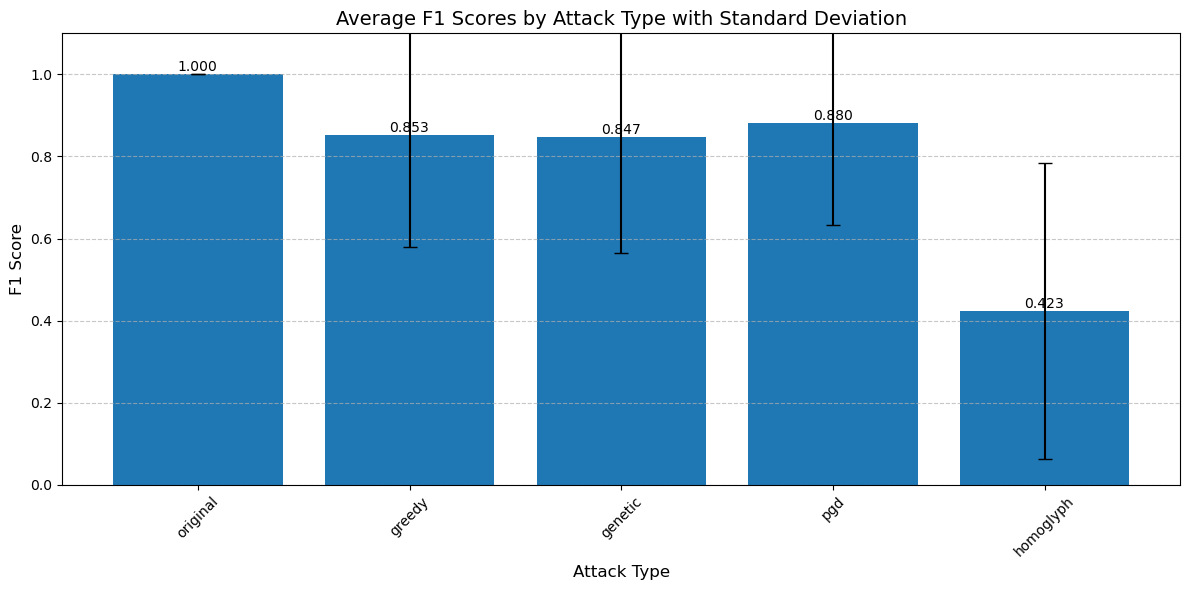

In [17]:
attack_types = ['original', 'greedy', 'genetic', 'pgd', 'homoglyph']
f1_scores = {attack: [] for attack in attack_types}

for item in total_results:  # Using total_results directly
    metrics = item[1]
    for attack in attack_types:
        f1_scores[attack].append(metrics[attack]['f1'])

# Calculate mean and standard deviation
means = {attack: np.mean(scores) for attack, scores in f1_scores.items()}
stds = {attack: np.std(scores) for attack, scores in f1_scores.items()}

# Prepare data for plotting
attacks = list(means.keys())
mean_values = list(means.values())
std_values = list(stds.values())

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(attacks, mean_values, yerr=std_values, capsize=5)

# Customize the plot
plt.title('Average F1 Scores by Attack Type with Standard Deviation', fontsize=14)
plt.xlabel('Attack Type', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.ylim(0, 1.1)  # F1 score range is 0-1

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()